# Some plots




In [1]:
import os
import odc.geo
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import xr_rasterize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
# from datacube.utils.dask import start_local_dask
# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

In [3]:
var = 'GPP'
version='v1.2'
base = f'/g/data/os22/chad_tmp/AusEFlux/'

### Open predictions

In [4]:
folder = base+f'results/AusEFlux/{var}/'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()

#combine annual files into one file
ds = xr.open_mfdataset(files)
ds = assign_crs(ds, crs='EPSG:4326')
ds.attrs['nodata'] = np.nan
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:              (time: 252, latitude: 680, longitude: 840)
Coordinates:
    spatial_ref          int32 4326
  * time                 (time) datetime64[ns] 2003-01-15 ... 2023-12-15
  * latitude             (latitude) float32 -10.02 -10.07 ... -43.92 -43.97
  * longitude            (longitude) float32 112.0 112.1 112.1 ... 153.9 154.0
Data variables:
    GPP_25th_percentile  (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_median           (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_75th_percentile  (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    nodata:       nan
    crs:          EPSG:4326
    short_name:   GPP
    long_name:    Gross Primary Productivity
    units:        gC/m²/month
    version:      v1.2
    description:  AusEFlux Gross Primary Productivity is created by empirical...

## Convert to PgC/year

In [5]:
grid = ds.odc.geobox.to_crs('EPSG:3577')
ds_area = ds.odc.reproject(how=grid, resampling='bilinear')

In [6]:
area_per_pixel = ds_area[var+'_median'].odc.geobox.resolution.x**2

if var != 'ET':
    ds_area = ds_area * area_per_pixel * 1e-15 * 12 # (pgC/year)
else:
    ds_area = ds_area * 12 # (mm/year)

## Zonal timeseries


In [7]:
ds_1D = ds_area[var+'_median'].rename(var).sum(['x','y'])
upper_1D = ds_area[var+'_25th_percentile'].sum(['x','y'])
lower_1D = ds_area[var+'_75th_percentile'].sum(['x','y'])

fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

if var == 'NEE':
    ds_fire_1d = ds_1D+fire
    ds_fire_1d.drop(['spatial_ref']).to_dataframe(name='NEE+fire')

annual_ds = ds_area.resample(time='1Y').sum()
annual_fire = fire.resample(time='1Y').sum()

print('This long-term mean: ', ds_1D.mean().values)

if var=='NEE':
    print('This long-term mean + fire: ', ds_fire_1d.mean().values)
print('This Study IAV (median model): ', (annual_ds[var+'_median'].sum(['x','y']) / 12).std().values)
print('This Study IAV (median model) + FIRE: ',((annual_ds[var+'_median'].sum(['x','y'])+annual_fire)/12).std().values)

ds_clim_mean = ds_area[var+'_median'].groupby('time.month').mean()
print('Seasonal range of '+var, ds_clim_mean.sum(['x','y']).max().values - ds_clim_mean.sum(['x','y']).min().values)

This long-term mean:  4.2836547
This Study IAV (median model):  0.5599902272224426
This Study IAV (median model) + FIRE:  0.5751050114631653
Seasonal range of GPP 1.5633265972137451


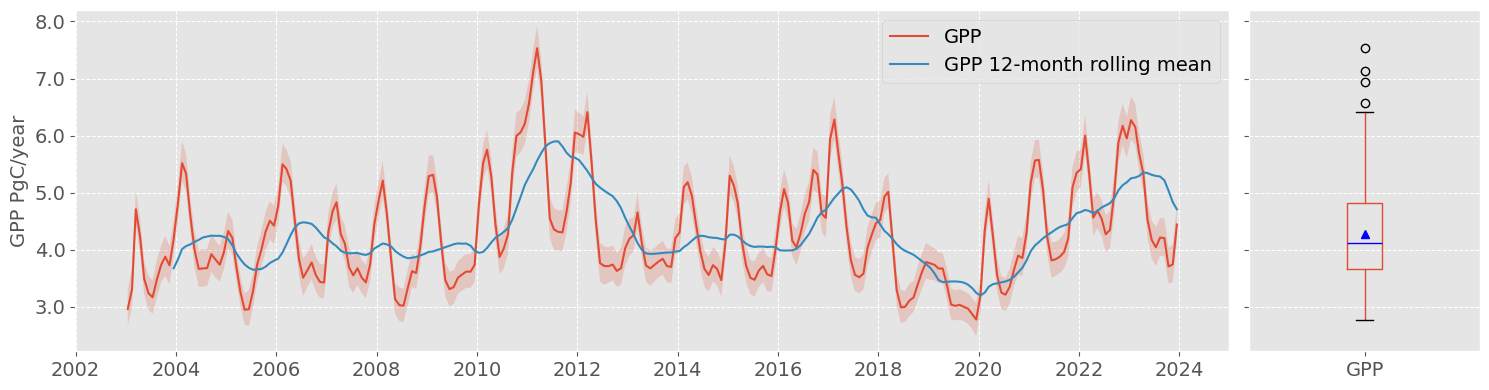

In [8]:
df_1d = ds_1D.drop(['spatial_ref']).to_dataframe()

with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,2, figsize=(15,4), sharey=True, gridspec_kw={'width_ratios': [5, 1]})
    
    if var == 'NEE':
        df_1d['NEE+fire'] = ds_fire_1d.drop(['spatial_ref']).to_dataframe(name='NEE+fire')
    
    ds_1D.plot(linestyle='-', ax=ax[0], label=var)
    ds_1D.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label=var+' 12-month rolling mean')
    ax[0].fill_between(ds_1D.time, lower_1D, upper_1D, alpha=0.2)
    df_1d.boxplot(ax=ax[1], rot=0, grid=False, fontsize=14, showmeans=True, color={'medians': 'blue'}, meanprops={'markerfacecolor': 'blue', 'markeredgecolor':'blue'})
    
    if var == 'NEE':
        
        ds_fire_1d.plot(linestyle='--', ax=ax[0], label='NEE+Fire', c='purple', alpha=0.5)
        ds_fire_1d.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE+fire 12-month rolling mean')
        ax[0].axhline(0, c='grey', linestyle='--')
        ax[1].axhline(0, c='grey', linestyle='--')
        
    if var != 'ET':
        ax[0].set_ylabel(var+' PgC/year', fontsize=14)
    else:
        ax[0].set_ylabel(var+' mm/year', fontsize=14)
    ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
    if var =='ER':
        ax[0].set_ylim(1.0, 8.0)
    
    if var =='NEE':
        ax[0].set_ylim(-2.2, 1.0)
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)
    ax[0].set_yticklabels(['{:3.1f}'.format(x) for x in ax[0].get_yticks()])
    ax[0].set_xlabel('')
    ax[0].set_title('')
    ax[0].grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
    ax[1].grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
    ax[0].legend(loc='best', fontsize=14)
    plt.tight_layout()
    
    plt.savefig(f'{base}results/figs/{var}_timeseries_with_boxplot_{version}.png', bbox_inches='tight', dpi=300)

### Annual bar graph

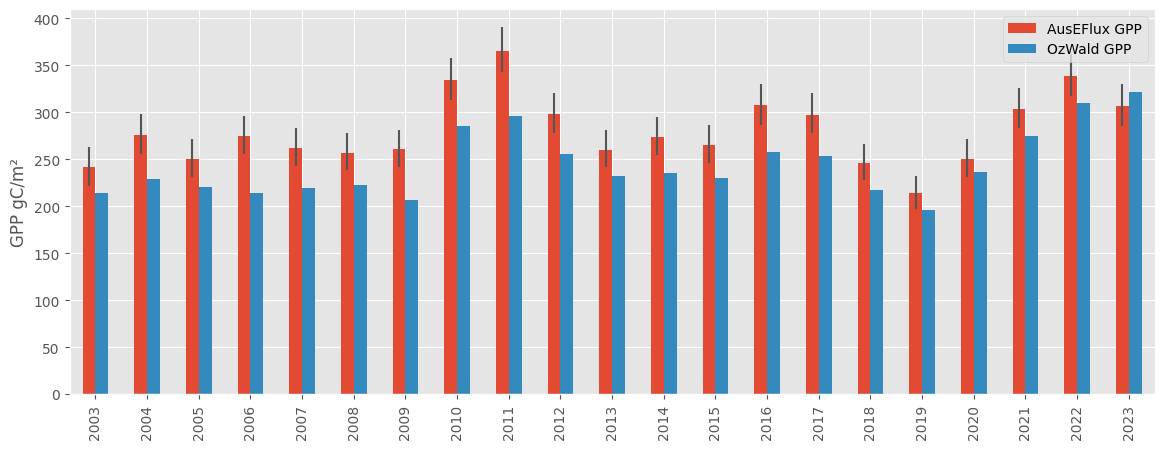

In [20]:
if var =='GPP':
    df = ds[var+'_median'].resample(time='1Y').sum().rename('AusEFlux GPP').mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
    df['lower'] = ds[var+'_25th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
    df['upper'] = ds[var+'_75th_percentile'].resample(time='1Y').sum().mean(['latitude','longitude']).drop('spatial_ref').to_dataframe()
    df.index = ds[var+'_median'].resample(time='1Y').sum().time.dt.year.values
    
    df['OzWald GPP'] = pd.read_csv('/g/data/os22/chad_tmp/AusEFlux/data/National_Vegetation carbon uptake_annual.csv', index_col='Year').rename({'Value':'OzWald'},axis=1)

    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(1,1, figsize=(14,5))
        df[['AusEFlux GPP', 'OzWald GPP']].plot(ax=ax, kind='bar',
                                                yerr={'AusEFlux GPP': [df['AusEFlux GPP'] - df['lower'],
                                                      df['upper'] - df['AusEFlux GPP']]
                                                     })
        ax.set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}')
        plt.savefig(f'{base}results/figs/{var}_annual_barplot_ozwald_{version}.png', bbox_inches='tight', dpi=300)

## Annual anomalies

In [10]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusEFlux/data/5km/rain_5km.nc').rain
rain = assign_crs(rain, crs='epsg:4326')
rain.attrs['nodata'] = np.nan

In [11]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.sel(time=slice('2003', '2023')).groupby("time.month").mean(),
            ds.sel(time=slice('2003', '2023')).groupby("time.month").std()
    )

rain_std_anom = stand_anomalies(rain)
ds_area_std_anom = stand_anomalies(ds_area[var+'_median'])
ds_std_anom = stand_anomalies(ds[var+'_median'])

In [12]:
roll=12

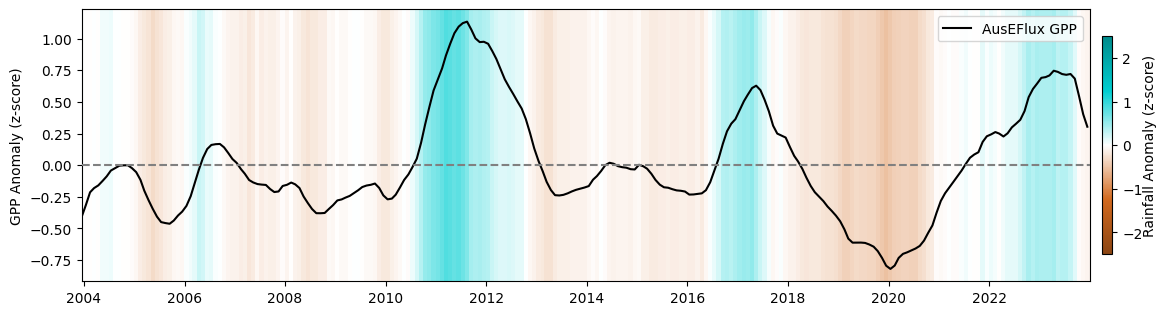

In [13]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['latitude','longitude']).sel(time=slice('2004', '2023')).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

# plt.style.use('default')
# with plt.style.context('ggplot'):
fig, ax = plt.subplots(1,1, figsize=(15,4))
ax2 = ax.twinx()

ds_area_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AusEFlux '+var, c='black')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title(None);
fig.savefig(f'{base}results/figs/{var}_anomalies_{roll}M.png',
                bbox_inches='tight', dpi=300)

## Per pixel summaries

In [14]:
annual_mean = ds[var+'_median'].resample(time='1Y').sum().mean('time')
annual_std = ds[var+'_median'].resample(time='1Y').sum().std('time')

scaled_variance = annual_std / annual_mean

In [15]:
monthly_mean = ds[var+'_median'].groupby('time.month').mean()

if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')

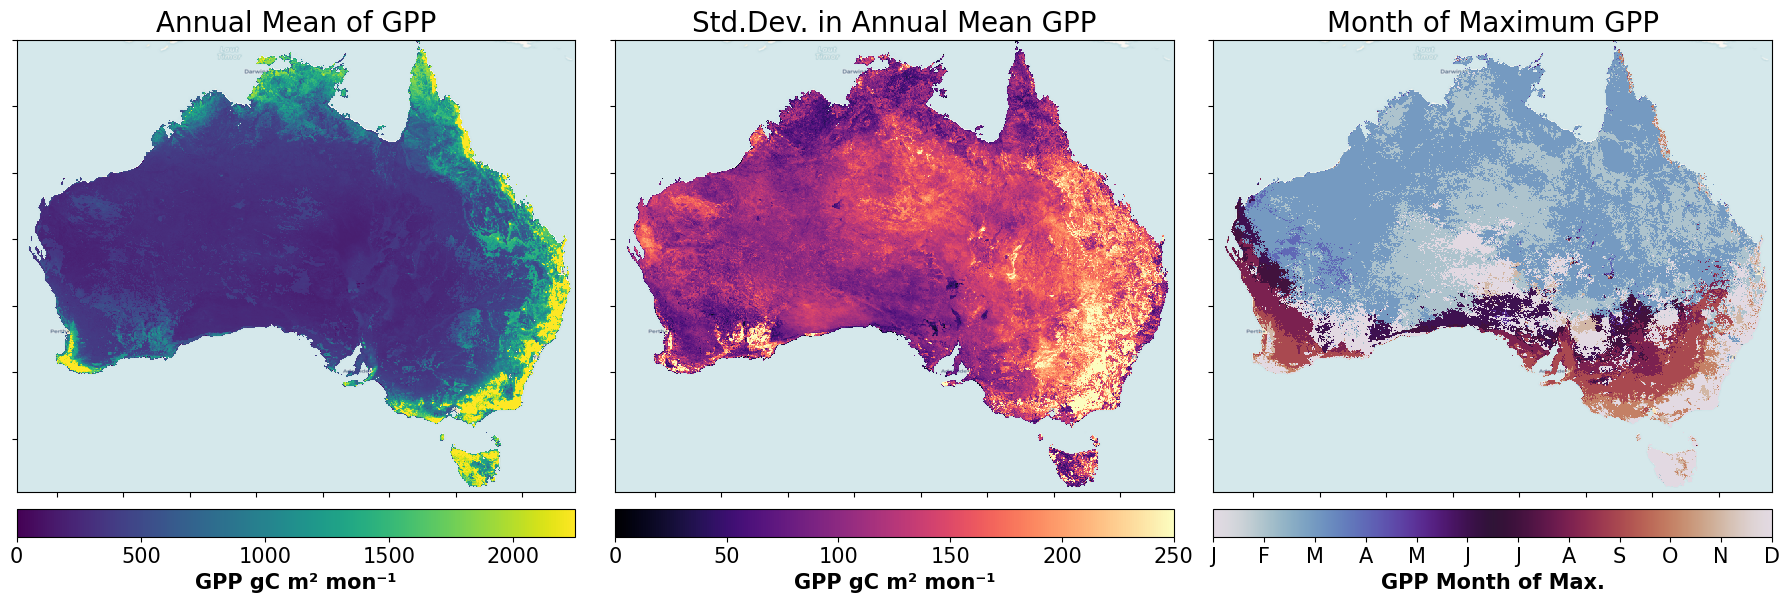

In [16]:
fig,ax = plt.subplots(1,3, figsize=(18,7), sharey=True)
font=20

if var == 'NEE':
    im = annual_mean.rename(var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹').where(annual_mean!=0).plot(ax=ax[0], cmap='Spectral_r',vmin=-300, vmax=300,add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    # cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.rename(var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹').where(annual_mean!=0).plot(ax=ax[0], cmap='viridis', vmin=0, vmax=2250, add_colorbar=False, add_labels=False)
    ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    

if var=='NEE':
    im1 = annual_std.rename('').where(annual_mean!=0).plot(ax=ax[1], cmap='magma',vmin=0, vmax=130, add_colorbar=False, add_labels=False)
    ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
else:
    im1 = annual_std.rename('').where(annual_mean!=0).plot(ax=ax[1], cmap='magma',vmin=0, vmax=250, add_colorbar=False, add_labels=False)
    ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.025, ax=ax[1])
cbar1.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

im2 = max_mean_month.plot(vmin=1, vmax=12, ax=ax[2], cmap='twilight', add_colorbar=False, add_labels=False)
ctx.add_basemap(ax[2], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.025)
cbar2.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar2.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
cbar2.set_label(label=var+' Month of Max.', size=15, weight='bold')

ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Std.Dev. in Annual Mean '+var, fontsize=font)

if var=='NEE':
    ax[2].set_title('Month of Maximum Carbon Uptake', fontsize=font);
else:
    ax[2].set_title('Month of Maximum '+var, fontsize=font);
    
plt.tight_layout();

plt.savefig(f'{base}results/figs/{var}_perpixel_summaries_{version}.png', bbox_inches='tight', dpi=300)

## Plot climatology

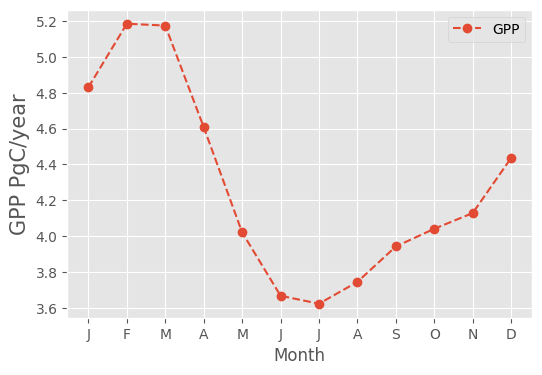

In [18]:
y = ds_area[var+'_median'].groupby('time.month').mean().sum(['x','y']).values
x = monthly_mean.month.values

if var=='NEE':
    y_fire = ds_fire_1d.groupby('time.month').mean()

with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(x, y, marker='o', linestyle='--', label=var)
    # ax.plot(x, y_fire, marker='o', linestyle='--', label='NEE+fire')
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
        ax.plot(x, y_fire, marker='o', linestyle='--', label='NEE+fire')
    # ax.fill_between(x, y-std, y+std, alpha=0.5)
    # ax.set_title('Monthly Mean '+var+' averaged over Australia')
    ax.legend()
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
    ax.set_xlabel('Month', fontsize=12);
    ax.set_ylabel(var+' PgC/year', fontsize=15);
plt.savefig(f'{base}results/figs/{var}_climatology_{version}.png', bbox_inches='tight', dpi=300)

In [ ]:
# ds_std_anom_annual = ds_std_anom.resample(time='1Y').mean()

In [ ]:
# data = [ds_std_anom_annual.drop('spatial_ref').sel(time='2010').squeeze(),
#         ds_std_anom_annual.drop('spatial_ref').sel(time='2011').squeeze(),
#         ds_std_anom_annual.drop('spatial_ref').sel(time='2022').squeeze(),
#         ds_std_anom_annual.drop('spatial_ref').sel(time='2023').squeeze()
#        ] 
# products=['2010','2011','2022','2023'] 

# fig,axes = plt.subplots(2,2, figsize=(10,10), sharey=True, layout='constrained')

# for ax, ds, n in zip(axes.ravel(), data, products):
#     im = ds.plot(cmap='RdYlGn', ax=ax, vmin=-2.5, vmax=2.5, add_colorbar=False)   
#     ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_title(f'{n}', fontsize=12)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
    
# # plt.subplots_adjust(wspace=0.075)
# cbar = fig.colorbar(im, orientation='horizontal',
#                                  ax=axes,
#                                  cmap='RdYlGn',
#                     label='Annual Mean GPP Anomaly (z-score)',
#                     shrink=0.50
#                    )
# fig.savefig(f'/g/data/os22/chad_tmp/AusEFlux/results/figs/{var}_annual_anomaly.png',
#             bbox_inches='tight', dpi=300);